# The code for automatically downloading SMAP data, obtains the moisture value for the Bangalore location, and then generates a time-series graph.

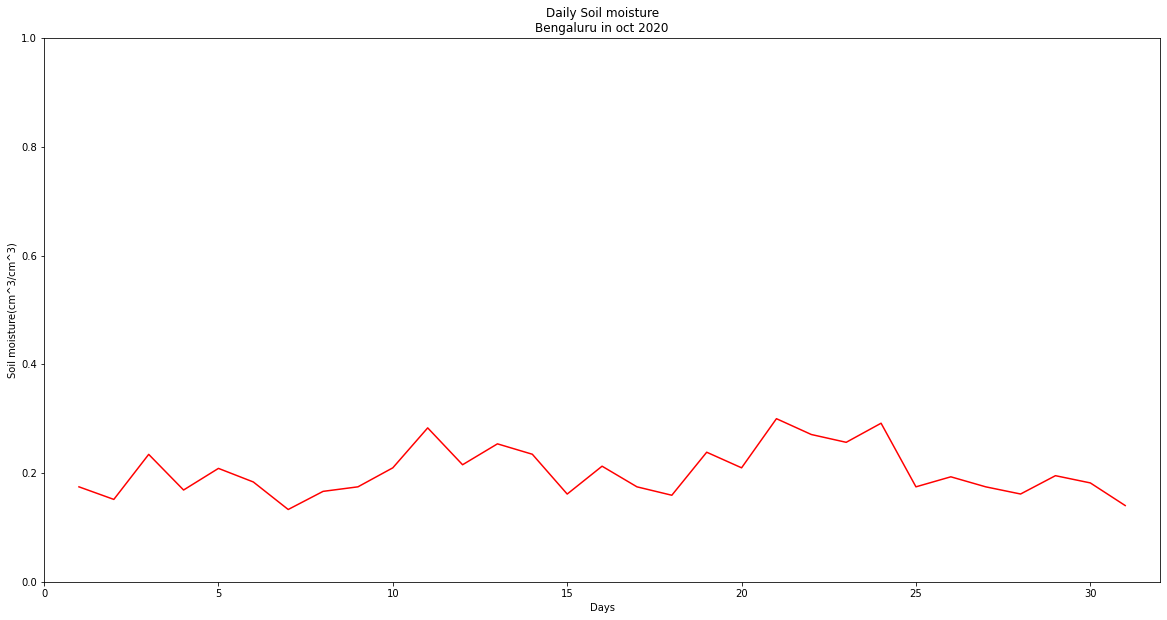

In [637]:
import os
import requests
import h5py
import numpy as np
import calendar
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd


#Start with downloading data
this_dir = os.getcwd()
DATA_DIR = os.path.join(this_dir, 'C:\Users\hp')

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
    
## to create a function to return the url and filename of the data we want to download.
## to download SMAP we will change only day. The rest of the filename is predictable.

def SMAP_L3_P_36km_Path(year, month, day):
    fpath_start = 'https://n5eil01u.ecs.nsidc.org/SMAP/'
    host = 'https://n5eil01u.ecs.nsidc.org/'
    version = '.004'
    url_path = '{host}/SMAP/SPL3SMP_E{version}/{year}.{month:02}.{day:02}/'.format(host=host,
                                                                                 version=version,
                                                                                 year=year,
                                                                                 month=month,
                                                                                 day=day)
    #SMAP_L3_SM_P_E_20201001_R17000_001.h5
    filename = 'SMAP_L3_SM_P_E_{year}{month:02}{day:02}_R17000_001.h5'.format(year=year, 
                                                                            month=month, 
                                                                            day=day)

    smap_data_path = url_path + filename
    
    return smap_data_path, filename

## variables for username and password 

username = '****************'
password = '****************'

assert username and password, 'Earthdata username and password!'

# Download data for Oct 2020
year = 2020
month = 10
_, days_in_month = calendar.monthrange(2020, 10)  # 31 days in Oct 2020


# here a requests session to keep track of authentication credentials
with requests.Session() as session:
    session.auth = (username, password)
    
    for day in range(1, days_in_month + 1):

        full_path, file_name = SMAP_L3_P_36km_Path(year, month, day)
        filepath = os.path.join(DATA_DIR, file_name)

        response = session.get(full_path)
        # If the response code is 401, we still need to authorize with earthdata.
        if response.status_code == 401:
            response = session.get(response.url)
        assert response.ok, 'Problem downloading data! Reason: {}'.format(response.reason)

        with open(filepath, 'wb') as f:
            f.write(response.content)

#### Now After downloading data we will retrive the moisture for the location of Bengaluru

#defining funtions
def Average(lst): 
    return sum(lst) / len(lst)
def soilm(accu_data):
    q = []
    m = []
    for value in accu_data:
        if value.size>0:
            q.append(value)
        if value.size==0:
            q.append(0)
    x = Average(q)
    for value in q:
        if value==0:
            m.append(x)
        else:
            m.append(value)
    return m


_, days_in_month = calendar.monthrange(2020, 10)
x = 2
date = []
accu_data1 = []
for day in range(1, days_in_month + 1):
    if day<32:
        hdffile = "SMAP_L3_SM_P_E_202010"+str(day).zfill(2)+"_R17000_001_HEGOUT.h5"
        date_temp = str(day).zfill(2)+"-"+"10"+"-"+"2020"
        date.append(date_temp)
        
        
        f = h5py.File(hdffile, mode='r')

        try:
            name = '/Soil_Moisture_Retrieval_Data_PM/soil_moisture_pm'
            latitude = f['/Soil_Moisture_Retrieval_Data_PM/latitude_pm'][:]
            longitude = f['/Soil_Moisture_Retrieval_Data_PM/longitude_pm'][:]

        except:
            name = '/Soil_Moisture_Retrieval_Data_AM/soil_moisture'
            latitude = f['/Soil_Moisture_Retrieval_Data_AM/latitude'][:]
            longitude = f['/Soil_Moisture_Retrieval_Data_AM/longitude'][:]

        def find_nearest(X, value):
            return X[np.unravel_index(np.argmin(np.abs(X - value)), X.shape)]


        box_lat = []
        box_lon = []
        lat = 12.97
        lon = 77.593
        nlat = find_nearest(latitude, lat)
        nlon = find_nearest(longitude, lon)
        box_lat.append(nlat)
        box_lon.append(nlon)


        lat_index = np.logical_and(latitude >= box_lat[0], latitude <=box_lat[0])

        lon_index = np.logical_and(longitude >= box_lon[0], longitude <= box_lon[0])

        box_index = np.logical_and(lat_index, lon_index)

        data = f[name][box_index]

    s = data.astype(np.float)
    accu_data1.append(s)

    
m = soilm(accu_data1)

df = pd.DataFrame(list(zip(date, m)), columns =['Date', 'Soil moisture'])


# Ploting time series graph
# data to be plotted 
x = df.index.values + 1
#since date can't be zero and indexing starts with zero so adding +1 with df.index.values
y = m
#plt.rcParams['figure.figsize'] = (30, 30)
fig, ax = plt.subplots(figsize=(20, 10))
#set axes range
plt.ylim([0, 1])
plt.xlim([0, 32])
  
# plotting
plt.title("Daily Soil moisture\nBengaluru in oct 2020")
plt.xlabel("Days")
plt.ylabel("Soil moisture(cm^3/cm^3)")
plt.plot(x, y, color ="red")
plt.show()